In [1]:
import numpy as np
import awkward as ak
np.random.seed(1337)  # for reproducibility

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model

from sklearn.metrics import roc_curve, auc, confusion_matrix

import matplotlib.pyplot as plt
import gc

import utils as pic

%load_ext autoreload
%autoreload 2

In [3]:
lr_init     = 1.e-5    # Initial learning rate  
batch_size  = 100       # Training batch size
train_size  = 2000     # Training size
valid_size  = 1000     # Validation size
test_size   = 1000     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU
tmin        = -0.1    # Minimum time cutoff
tmax        = 0.1     # Maximum time cutoff
tstep       = 0.0085   # Time steps

In [4]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(pic.decays)*train_size) % batch_size == 0
X_train, y_train = pic.load_data(train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = pic.load_data(valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = pic.load_data(test_start,test_stop)

samples_requested = len(pic.decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [5]:
X_train, X_t_train, maxframes, time_bins = pic.timeordered_BC(X_train, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep )

scaler = pic.MinMaxScaler(0.001).fit(X_train)
X_train = scaler.transform(X_train)
y_b_train = to_categorical(y_train)

In [6]:
X_valid, X_t_valid, maxframes, time_bins = pic.timeordered_BC(X_valid, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep )
X_valid = scaler.transform(X_valid)
y_b_valid = to_categorical(y_valid)


In [7]:
X_test, X_t_test, _, _ = pic.timeordered_BC(X_test, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep)
X_test = scaler.transform(X_test)
y_b_test = to_categorical(y_test)


In [9]:
input_img = keras.Input(shape=(maxframes, 32, 32)) # shape (24,32,32,1)

def encoding_layer(previous,nfilters,conv_shape,pool_shape):
    x = layers.Conv3D(nfilters, conv_shape, padding='same', use_bias=False)(previous)
    x = layers.ReLU()(x)
    encoded = layers.MaxPooling3D(pool_shape, padding='same')(x)
    return encoded

# Encoder
x = layers.Reshape((maxframes, 32, 32, 1))(input_img)
encoded = encoding_layer(x,16,3,2)
encoded = encoding_layer(encoded,8,3,2)
# encoded = encoding_layer(encoded,8,3,2)
# Encoded shape (3,4,4,8)

def decoding_layer(previous,nfilters,conv_shape,samp_shape):
    x = layers.Conv3D(nfilters,conv_shape, padding='same', use_bias=False)(previous)
    x = layers.ReLU()(x)
    decoded = layers.UpSampling3D(samp_shape)(x)
    return decoded

# decoded = decoding_layer(encoded,8,3,2)
decoded = decoding_layer(encoded,8,3,2)
decoded = decoding_layer(decoded,16,3,2)
decoded = layers.Conv3D(1, (3, 3, 3), activation='relu', padding='same', use_bias=False)(decoded)
decoded = layers.Reshape((maxframes, 32, 32))(decoded)
# Decoded shape (24,32,32,1)

autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 32, 32)]      0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 24, 32, 32, 1)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 24, 32, 32, 16)    432       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 24, 32, 32, 16)    0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 12, 16, 16, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 12, 16, 16, 8)     3456      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 12, 16, 16, 8)     0     

In [10]:
autoencoder.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=lr_init),metrics=['accuracy'])

In [11]:
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_valid,X_valid),
    epochs=2,
    batch_size=50,
    shuffle=True,
    verbose=1
)

Epoch 1/2
80/80 [==============================] - 204s 3s/step - loss: 0.0046 - accuracy: 0.0455 - val_loss: 0.0037 - val_accuracy: 0.0477
Epoch 2/2
80/80 [==============================] - 196s 2s/step - loss: 0.0034 - accuracy: 0.0513 - val_loss: 0.0031 - val_accuracy: 0.0520


In [12]:
gc.collect()

1597

In [13]:
X_test_reconst = autoencoder.predict(X_test)

In [14]:
X_test_reconst_flat = np.sum(X_test_reconst,axis=1)
X_test_flat = np.sum(X_test,axis=1)

In [15]:
X_test_flat.shape

(2000, 32, 32)

In [16]:
def plot_image(X,mask_zero=True,figax=None):
    if figax is None: figax = plt.subplots()
    fig,ax = figax 
    if mask_zero: X = np.where(X==0,np.nan,X)
    ax.imshow(X)

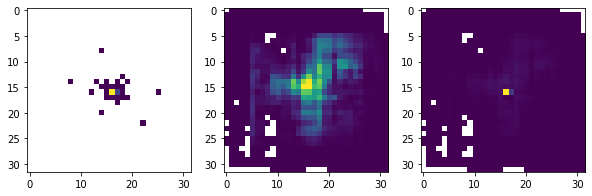

In [17]:
event = 23

fig,axs = plt.subplots(ncols=3,figsize=(10,5))
plot_image(X_test_flat[event],figax=(fig,axs[0]))
plot_image(X_test_reconst_flat[event],figax=(fig,axs[1]))
plot_image(np.abs(X_test_flat[event]-X_test_reconst_flat[event]),figax=(fig,axs[2]))
plt.show()